In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import nn

import matplotlib.pyplot as plt

from nn_functions import init_network_params, pack_params, layer_sizes, unpack_params
from nn_functions import  update_sgd, compute_hessian, update_adam
from nn_functions import get_batches, loss, batched_predict, batched_predict_with_activations

In [3]:
# Load data
field = jnp.load('field.npy')
field = field - field.mean()
field = field / field.std()
field = jnp.array(field, dtype=jnp.float32)
nx, ny = field.shape
xx = jnp.linspace(-1, 1, nx)
yy = jnp.linspace(-1, 1, ny)
xx, yy = jnp.meshgrid(xx, yy, indexing='ij')
xx = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
ff = field.reshape(-1, 1)

In [64]:
xx.shape

(77184, 2)

In [81]:
from jax import random, grad
from jax.tree_util import tree_map
import jax.numpy as jnp

def train_model(
    num_epochs=400,
    rng_key=random.key(0),
    batch_size=64,
    step_size=0.005,
    update=update_adam,
    patience=10,
    tol_loss=1e-5
):
    # Inicializar red
    params = init_network_params(layer_sizes, rng_key)
    params = pack_params(params)

    # Inicializar Adam (o SGD si se adapta la interfaz)
    aux_m = tree_map(jnp.zeros_like, params)
    aux_v = tree_map(jnp.zeros_like, params)
    aux_t = 0
    aux = (aux_m, aux_v, aux_t)

    # Logging
    log_train = []
    log_grads = []
    log_activations = []
    log_hessian = []

    # Early stopping
    best_loss = float('inf')
    wait = 0

    for epoch in range(num_epochs):
        idxs = random.permutation(rng_key, xx.shape[0])
        for xi, yi in get_batches(xx[idxs], ff[idxs], bs=batch_size):
            params, aux, grads = update(params, xi, yi, step_size, aux)

        train_loss = loss(params, xx, ff)
        log_train.append(train_loss.item())

        # Early stopping
        if train_loss < best_loss - tol_loss:
            best_loss = train_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Corte temprano por paciencia en epoch {epoch}")
                break

        # Logging cada 20 epochs
        if epoch % 10 == 0:
            grads = grad(loss)(params, xx, ff)
            log_grads.append(grads)
            outputs, activations = batched_predict_with_activations(params, xx)
            log_activations.append(activations)
            xi, yi = next(get_batches(xx, ff, bs=batch_size))  # para el Hessiano
            log_hessian.append(compute_hessian(params, xi, yi))
            print(f"Epoch {epoch}, Loss: {train_loss}")

    return {
        "params": params,
        "log_train": log_train,
        "log_grads": log_grads,
        "log_activations": log_activations,
        "log_hessian": log_hessian,
        "final_epoch": epoch,
        "final_loss": train_loss.item()
    }

In [82]:
"""
A mayor batch_size, suele hacer falta un learning_rate más alto.
A menor batch_size, conviene un learning_rate más bajo.
"""
results = train_model( num_epochs=100,
    rng_key=random.key(65),
    batch_size=64,
    step_size=0.005,
    update=update_adam,
    patience=30,
    tol_loss=1e-5)

Epoch 0, Loss: 0.06840823590755463
Epoch 10, Loss: 0.032237760722637177
Epoch 20, Loss: 0.030960405245423317
Epoch 30, Loss: 0.02672305516898632
Epoch 40, Loss: 0.023798758164048195
Epoch 50, Loss: 0.021582603454589844
Epoch 60, Loss: 0.0194491446018219
Epoch 70, Loss: 0.01773824356496334
Epoch 80, Loss: 0.017257504165172577
Epoch 90, Loss: 0.016838788986206055


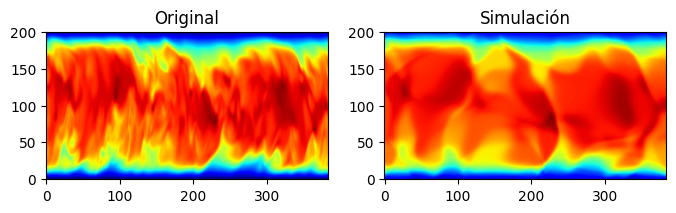

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].imshow(ff.reshape((nx, ny)).T, origin='lower', cmap='jet')
axes[0].set_title(f"Original")
result= batched_predict(results["params"], xx)
axes[1].imshow(result.reshape((nx, ny)).T, origin='lower', cmap='jet')
axes[1].set_title(f"Simulación")

plt.show()

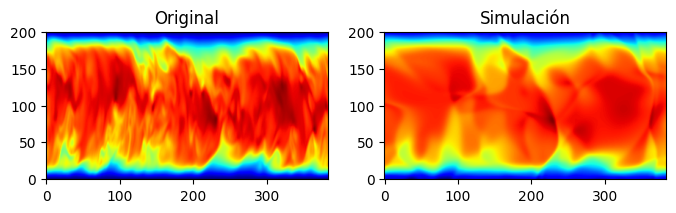

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].imshow(ff.reshape((nx, ny)).T, origin='lower', cmap='jet')
axes[0].set_title(f"Original")
result= batched_predict(results["params"], xx)
axes[1].imshow(result.reshape((nx, ny)).T, origin='lower', cmap='jet')
axes[1].set_title(f"Simulación")

plt.show()

In [83]:
# Inicializamos estructuras para acumular gradientes
num_layers = len(layer_sizes) - 1
grad_weights_by_layer = [[] for _ in range(num_layers)]
grad_biases_by_layer = [[] for _ in range(num_layers)]
log_grads = results["log_grads"]
# Recolectamos gradientes por capa y tipo
for grads in log_grads:
    layer_grads = unpack_params(grads)  # Lista de (w, b) por capa
    for i, (w, b) in enumerate(layer_grads):
        grad_weights_by_layer[i].append(w.flatten())
        grad_biases_by_layer[i].append(b.flatten())

In [45]:
len(grad_weights_by_layer[0])

5

In [22]:
for i, grad_list in enumerate(grad_weights_by_layer):
    print(grad_list)

[Array([ 0.00541304, -0.00590672,  0.00433146,  0.02244084, -0.03658722,
        0.08993657,  0.01974314, -0.04030368, -0.02018933,  0.01236954,
        0.02259662, -0.04452064,  0.01115081, -0.05612382, -0.00164272,
        0.03880509,  0.00949433, -0.04503945, -0.00361362,  0.05032124,
       -0.02571918,  0.0806102 , -0.04787007,  0.14217304,  0.0173134 ,
       -0.04894279,  0.04680414, -0.15499185,  0.01157388, -0.03444341,
        0.01667818, -0.05445342, -0.007005  , -0.01083678,  0.01719541,
       -0.07039278,  0.02376392, -0.05279627,  0.00329008, -0.00707469,
       -0.01078821,  0.01906751,  0.02152675, -0.00673387, -0.03805273,
        0.16834067,  0.03546076, -0.11841616,  0.01476477, -0.04021477,
       -0.0094604 ,  0.01815099, -0.03014763,  0.08329793,  0.00639142,
       -0.01699867,  0.0168337 , -0.07602577, -0.00215391, -0.00545652,
       -0.00507585, -0.00772675, -0.00200011, -0.04101272,  0.01907071,
       -0.0966433 , -0.00670525,  0.05740482,  0.00958448, -0.0

In [54]:


# Colores por epoch
#epochs = [i * 20 for i in range(len(log_grads))]
colors = ['blue', 'orange', 'green', 'red', 'purple']  # Asegurate de tener >= len(log_grads)

# Función auxiliar para graficar
def plot_histograms(data_by_layer, param_type):
    for i, grad_list in enumerate(data_by_layer[:-1]):
        plt.figure(figsize=(8, 5))
        for j, grad_values in enumerate(grad_list):
            if j == 0 or j ==1 or j==int(len(grad_list)/2) or j==int(len(grad_list)):
                plt.hist(grad_values, bins=50, alpha=0.5, density=True)
                #   label=f"Epoch {epochs[j]}", color=colors[j])
        plt.title(f"Gradientes de {param_type} - Capa {i+1}")
        plt.xlabel("Valor del gradiente")
        plt.ylabel("Densidad")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()



In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distributions(data_by_layer, param_type):
    for i, layer_data in enumerate(data_by_layer[:-1]):  # layer_data: lista de arrays (uno por época)
        plt.figure(figsize=(8, 5))
        for j, values in enumerate(layer_data):
            if  j == 1 or j == int(5) or j == len(layer_data)-1:
                sns.kdeplot(values, label=f"j = {j}", linewidth=2)
        plt.title(f"Distribución de {param_type} - Capa {i+1}")
        plt.xlabel("Valor")
        plt.ylabel("Densidad estimada")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


In [ ]:
# Graficar pesos y luego biases
plot_histograms(grad_weights_by_layer, "pesos")
plot_histograms(grad_biases_by_layer, "biases")

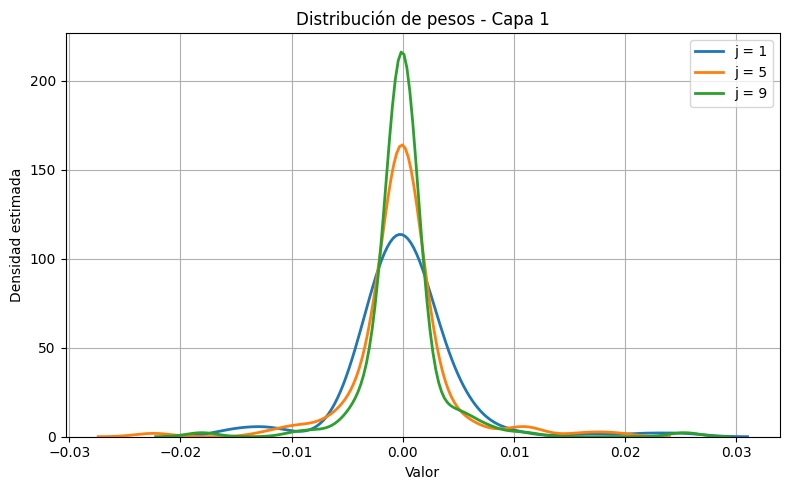

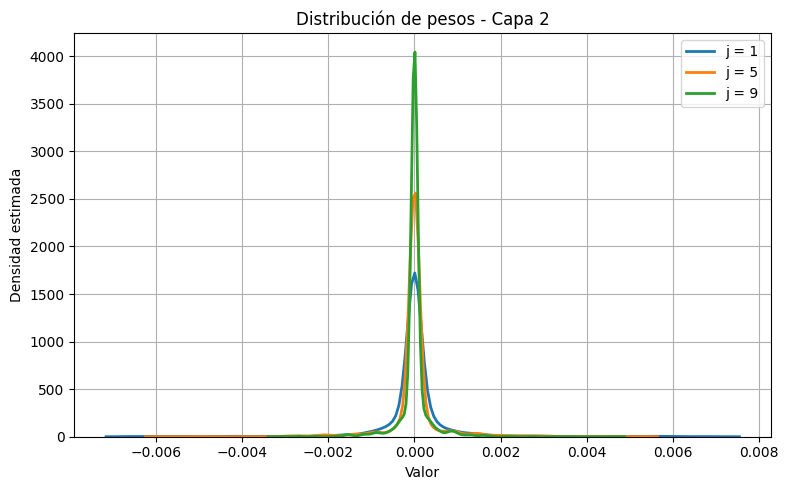

In [86]:
plot_distributions(grad_weights_by_layer, "pesos")

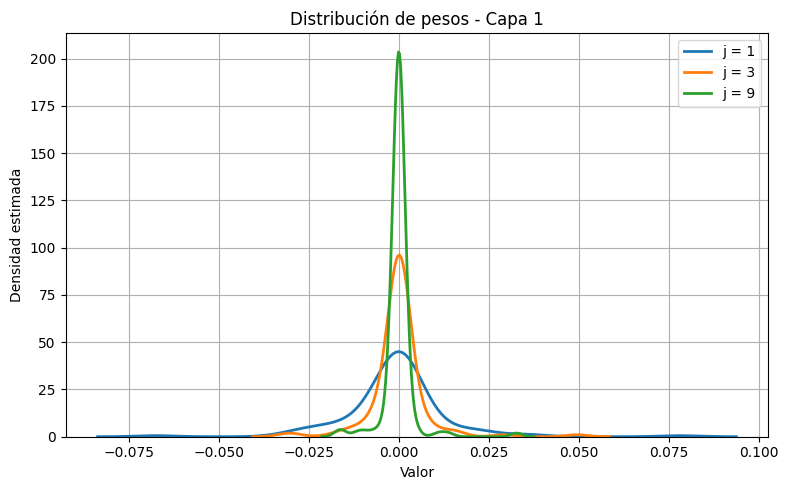

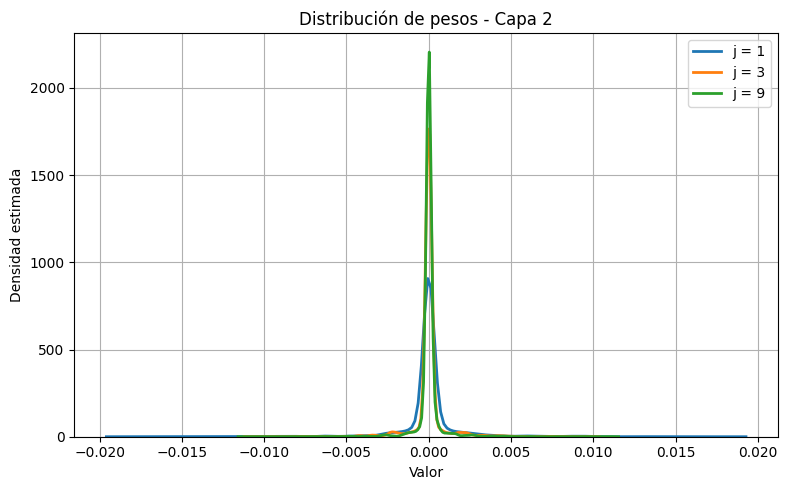

In [56]:
plot_distributions(grad_weights_by_layer, "pesos")

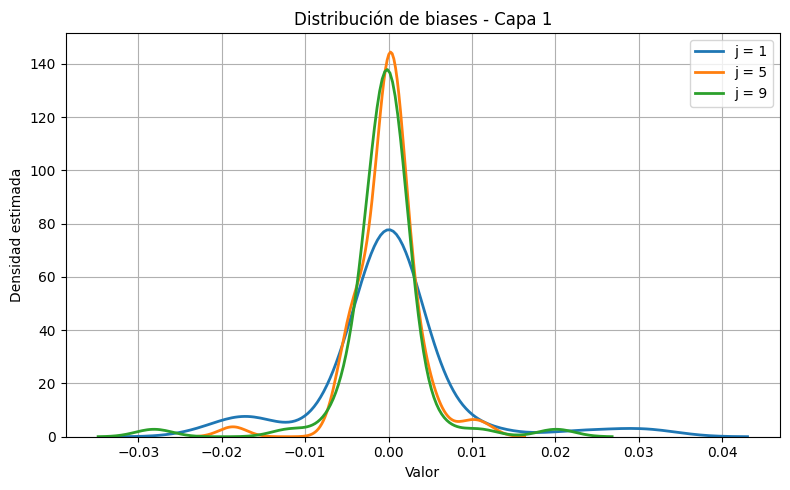

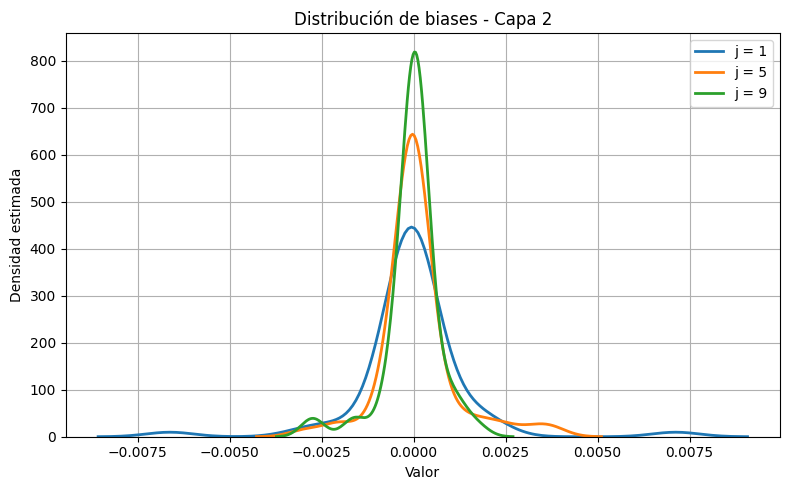

In [87]:
plot_distributions(grad_biases_by_layer, "biases")